In [24]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve

import matplotlib

from fredapi import Fred
fred = Fred(api_key="efedf207a63071188c699caf884a4ee9")

In [25]:
data_list = ['CLF16OV','JTSHIL','JTSJOL','UNEMPLOY']

for i in range(len(data_list)):
    s = data_list[i]
    if i == 0:
        data = fred.get_series(s)
    else:
        data = pd.concat([data,fred.get_series(s)],axis=1)
        print(s)
data.columns = data_list
print('success')

JTSHIL
JTSJOL
UNEMPLOY
success


In [26]:
data.columns = ['F','H','V','U']
data = data.dropna(how='any',axis=0)
data

,F,H,V,U
2000-12-01,143248.0,5426.0,5088.0,5634.0
2001-01-01,143800.0,5722.0,5234.0,6023.0
2001-02-01,143701.0,5303.0,5097.0,6089.0
2001-03-01,143924.0,5528.0,4762.0,6141.0
2001-04-01,143569.0,5204.0,4615.0,6271.0
...,...,...,...,...
2024-02-01,167426.0,5781.0,8813.0,6458.0
2024-03-01,167895.0,5617.0,8355.0,6429.0
2024-04-01,167982.0,5615.0,7919.0,6492.0
2024-05-01,167732.0,5655.0,8230.0,6649.0


In [27]:
# モデルのパラメータ
a_h = 0.0027
b_h = 14.2464
a_l = 0.1140
b_l = 0.2168
eta = 0.3155

# thetaの閾値
theta_bar = 1.0

<Axes: title={'center': 'theta'}>

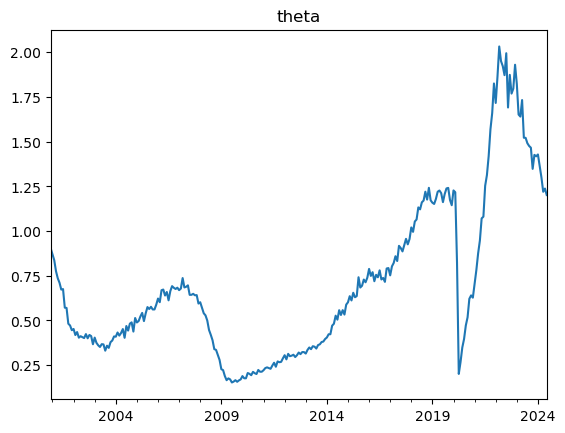

In [44]:
# 求人倍率の計算
data.loc[:,'theta'] = data['V']/data['U']
data['theta'].plot(title='theta')

<Axes: title={'center': 'm'}>

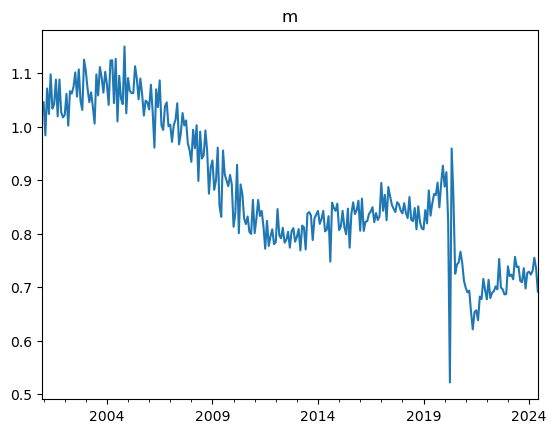

In [43]:
# マッチング効率の計算
data.loc[:,'m']=data['H']/((data['U']**eta)*(data['V']**(1-eta)))
data['m'].plot(title='m')

<Axes: title={'center': 'z'}>

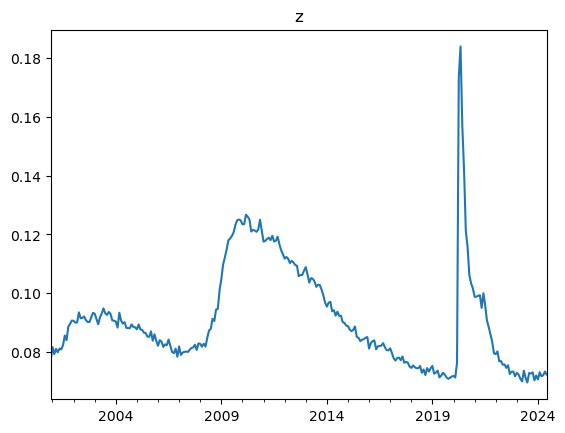

In [42]:
# unattached workerの計算
data.loc[:,'z']=(data['H']+data['U'])/data['F']
data['z'].plot(title='z')

<Axes: title={'center': 'Fig.27'}, xlabel='theta', ylabel='z'>

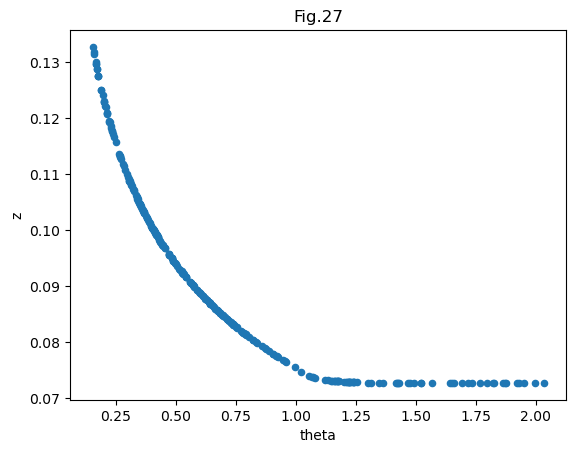

In [52]:
# Fig27をプロットするためのデータ
theta_list = sorted(list(set(data['theta'].to_list())))
fig27 = pd.DataFrame(columns=['z','theta'])
for i in range(len(theta_list)):
    s = theta_list[i]
    fig27.loc[i,'theta'] = s
    if s >= 1:
        fig27.loc[i,'z'] = 0.0754 - a_h + a_h*(s**(-b_h))
    else:
        fig27.loc[i,'z'] = 0.0754 - a_l + a_l*(s**(-b_l))
fig27.plot.scatter(x='theta',y='z',title='Fig.27')

<Axes: title={'center': 'Fig.28'}>

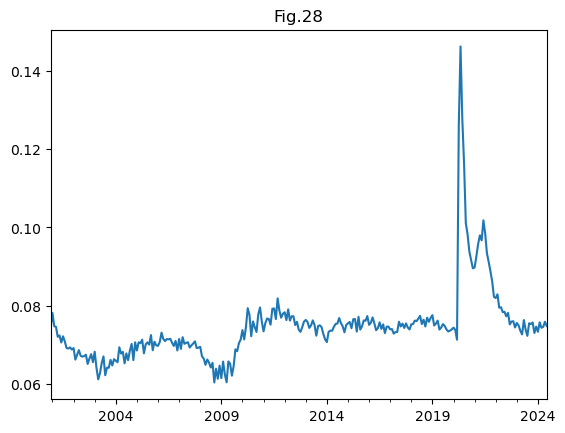

In [60]:
data.loc[:,'z~']=np.nan
idx_z_ = list(data.columns).index('z~')
idx_z = list(data.columns).index('z')
for i in range(data.shape[0]):
    s = data.iloc[i,4]
    if s >= 1:
        data.iloc[i,idx_z_] = data.iloc[i,idx_z] + a_h - a_h*(s**(-b_h))
    else:
        data.iloc[i,idx_z_] = data.iloc[i,idx_z] + a_l - a_l*(s**(-b_l))
data['z~'].plot(title='Fig.28')

In [62]:
data.loc[:,'u']=data['U']/data['F']
data.loc[:,'v']=data['V']/data['F']
data

,F,H,V,U,theta,m,z,z~,u,v
2000-12-01,143248.0,5426.0,5088.0,5634.0,0.903088,1.032680,0.077209,0.074661,0.039330,0.035519
2001-01-01,143800.0,5722.0,5234.0,6023.0,0.869002,1.045864,0.081676,0.078152,0.041885,0.036398
2001-02-01,143701.0,5303.0,5097.0,6089.0,0.837083,0.983650,0.079276,0.074795,0.042373,0.035469
2001-03-01,143924.0,5528.0,4762.0,6141.0,0.775444,1.071351,0.081078,0.074615,0.042668,0.033087
2001-04-01,143569.0,5204.0,4615.0,6271.0,0.735927,1.023651,0.079927,0.072091,0.043679,0.032145
...,...,...,...,...,...,...,...,...,...,...
2024-02-01,167426.0,5781.0,8813.0,6458.0,1.364664,0.723569,0.073101,0.075769,0.038572,0.052638
2024-03-01,167895.0,5617.0,8355.0,6429.0,1.299580,0.730235,0.071747,0.074383,0.038292,0.049763
2024-04-01,167982.0,5615.0,7919.0,6492.0,1.219809,0.754926,0.072073,0.074614,0.038647,0.047142
2024-05-01,167732.0,5655.0,8230.0,6649.0,1.237780,0.734957,0.073355,0.075926,0.039641,0.049066


In [110]:
data.loc[:,'v_star']=np.nan
idx_theta = list(data.columns).index('theta')
idx_u = list(data.columns).index('u')
idx_m = list(data.columns).index('m')
idx_z_ = list(data.columns).index('z~')
idx_v_star = list(data.columns).index('v_star')

m0 = data.iloc[-1,idx_m]
z0 = data.iloc[-1,idx_z_]

be_beveradge1 = []
be_beveradge2 = []

u_list = np.linspace(0.03, 0.05, 50).tolist() + np.linspace(0.05, 0.15, 20).tolist()

for i in u_list:
    u = i

    a = a_h
    b = b_h
    
    def equation(v):
        v = max(v, u)
        uv1 = (u**eta) * (v**(1-eta))
        uv2 = (u**b) * (v**(-b))
        return m0 * uv1 - z0 - a * (uv2 - 1) + u
    
    # 初期推定値を設定
    initial_guess = u
    
    # 方程式を解いてvを計算
    v_solution = fsolve(equation, initial_guess)
    
    # 結果を保存
    be_beveradge1 += [[u,v_solution[0]]]

df1 = pd.DataFrame(be_beveradge1)
df1.loc[:,'chk']=0
for i in range(df1.shape[0]):
    if df1.iloc[i,1] <= df1.iloc[i,0]:
        df1.iloc[i,-1] = 1

#df1[df1['chk']==0].plot.scatter(x=0,y=1,grid=True)

/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [111]:
for i in u_list:
    u = i

    a = a_l
    b = b_l
    
    def equation(v):
        v = max(min(v, u),1e-8)
        uv1 = (u**eta) * (v**(1-eta))
        uv2 = (u**b) * (v**(-b))
        return m0 * uv1 - z0 - a * (uv2 - 1) + u
    
    # 初期推定値を設定
    initial_guess = u
    
    # 方程式を解いてvを計算
    v_solution = fsolve(equation, initial_guess)
    
    # 結果を保存
    be_beveradge2 += [[u,v_solution[0]]]

df2 = pd.DataFrame(be_beveradge2)
df2.loc[:,'chk']=0
for i in range(df2.shape[0]):
    if df2.iloc[i,1]>=df2.iloc[i,0]:
        df2.iloc[i,-1] = 1

#df2[df2['chk']==0].plot.scatter(x=0,y=1)

/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Axes: xlabel='u', ylabel='v'>

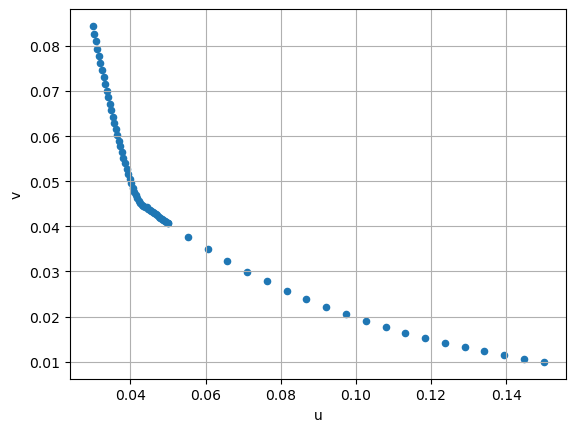

In [112]:
dfx = pd.concat([df1[df1['chk']==0],
                 df2[df2['chk']==0]],axis=0).iloc[:,:2]
dfx.columns = ['u','v']
dfx.plot.scatter(x='u',y='v',grid=True)

In [120]:
(data.loc[:,['u','v']]*100).to_excel('uv_data0.xlsx')

In [121]:
dfx = dfx*100
dfx.loc[:,'theta']=dfx['v']/dfx['u']
dfx.to_excel('equilibrium.xlsx')